In [1]:
from qiskit.opflow import StateFn, PauliExpectation
from qiskit import QuantumCircuit,Aer, assemble
from qiskit.opflow.state_fns import CircuitStateFn
from qiskit.circuit.library import EfficientSU2,TwoLocal,NLocal
from qiskit.circuit import Parameter,ParameterVector
from qiskit import Aer,transpile
from qiskit.utils import QuantumInstance
from qiskit.opflow.converters import CircuitSampler
from math import *
import numpy as np
import matplotlib.pyplot as plt
# 
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper , ParityMapper
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP,L_BFGS_B,CG
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers import FreezeCoreTransformer,BaseTransformer
from sympy import symbols
from qiskit_nature.algorithms import VQEUCCFactory,GroundStateEigensolver
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer import AerSimulator


/home/gsilvi/miniforge3/envs/NEASQC4/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
# import the modified pieces of LinCombFull and LinComb to perform an imaginary time evolution, pass them directly to NaturalGradient()
from qiskit_mod.qiskit_ter import LinCombFullmod,LinCombMod

In [3]:
# Initialize qubit converter
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True) #two qubit reduction doesn`t work with Jordan-Wigner

# Initialize Exact solvers & VQE solver
numpy_solver = NumPyMinimumEigensolver()



#NOISE
usenoise=False  #HERE CHOOSE TO USE THE NOISE 
if usenoise:
    device_backend = FakeVigo()
    simulator = AerSimulator.from_backend(device_backend)
    
else:
    simulator = Aer.get_backend('statevector_simulator')
    
quantum_instance = QuantumInstance(backend = simulator)
optimizer = L_BFGS_B(maxiter=1000)

# choose a distance to test
bond_distance= 0.75

# Set the Hydrogen molecule
molecule = 'H .0 .0 -{0}; H .0 .0 {0}'
driver = PySCFDriver(atom = molecule.format(bond_distance/2), unit=UnitsType.ANGSTROM, basis='sto3g')

es_problem = ElectronicStructureProblem(driver)  

# Get the qubit Hamiltonian
second_q_op = es_problem.second_q_ops()
qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
print('The qubit Hamiltonian: \n',qubit_op)

# Separate coefficients from Pauli operators in the Hamilt.
char_list = str(qubit_op).split()
hamil_parts= [ c for c in char_list if c.isalpha()]
dict_coeff={}
for i in range(len(qubit_op.coeffs)):
	dict_coeff[i] = np.real(qubit_op.coeffs[i])

print("Coefficients:", dict_coeff,"\n Pauli Op.:", hamil_parts)


The qubit Hamiltonian: 
 (-1.0554030320779284-2.7755575615628914e-17j) * II
+ (-0.3887475880915992-1.3877787807814457e-17j) * ZI
+ (0.3887475880915992+2.7755575615628914e-17j) * IZ
- 0.01117714476252557 * ZZ
+ 0.18177153657730488 * XX
Coefficients: {0: -1.0554030320779284, 1: -0.3887475880915992, 2: 0.3887475880915992, 3: -0.01117714476252557, 4: 0.18177153657730488} 
 Pauli Op.: ['II', 'ZI', 'IZ', 'ZZ', 'XX']


In [4]:
# Find ground state for comparison (both VQE and exact)

# Initialize VQE solver
vqe_solver = VQEUCCFactory(quantum_instance, optimizer=optimizer)
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
vqe_energies = res.total_energies
print('Ground state energy from VQE ',vqe_energies)

# Initialize Exact solvers 
exact_calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res_exact = exact_calc.solve(es_problem)
exact_energy = res_exact.total_energies
print('Ground state energy from numpy solver ',exact_energy)


Ground state energy from VQE  [-1.13711707]
Ground state energy from numpy solver  [-1.13711707]


In [5]:
def universal_ansatz(params) -> QuantumCircuit:
	ua = QuantumCircuit(2)
	ua.ry(params[0],0)
	ua.rz(params[1],0)

	ua.ry(params[2],1)
	ua.rz(params[3],1)

	ua.cnot(0,1)

	ua.ry(params[4],0)
	ua.rz(params[5],0)

	ua.ry(params[6],1)
	ua.rz(params[7],1)
	return ua



def measure_H_energy(sampler, angles, hamiltonian) -> float:
	ua = universal_ansatz(angles)
	measurement=StateFn(hamiltonian, is_measurement=True)#.adjoint()
	final_circuit=measurement@CircuitStateFn(ua)
	PE = PauliExpectation().convert(final_circuit)
	out=sampler.convert(PE)
	return out.eval()


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)



In [10]:
T = 5 #final time 
number_of_steps = T*10
dt=T/number_of_steps
timesteps=np.linspace(0.,T,number_of_steps)
numRep = 8  # number of parameters in the Universal ansatz used

# Starting point
initial_angles = [np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi]
#initial_angles = [0,0,0,0,0,0,0,0]
#initial_angles = np.random.rand(numRep)*np.pi


sampler = CircuitSampler(backend=simulator)


# Initialize the universal ansatz to represent H2
value_dict={}
if True:
    angles_params = []
    # Initialize parameters to initial angles
    syms=symbols('θ_0:%d'%numRep)
    for i,sym in enumerate(syms):
        par = Parameter(str(sym))
        angles_params.append(par)
        value_dict[par]= initial_angles[i]
    univ_ans = universal_ansatz(angles_params)
else:
    #Experimental: still haven`t managed to make it work with TwoLocal()
    univ_ans = TwoLocal(2, rotation_blocks=['ry','rz'],  entanglement_blocks='cx', entanglement="full", reps=1, parameter_prefix='a')
    
    #univ_ans = EfficientSU2(2, reps=1)
    #univ_ans._build()
    print(univ_ans)
    #univ_ans.decompose()
    #univ_ans = univ_ans.assign_parameters(initial_angles)
    #angles_params=univ_ans._parameter_table.keys()
    angles_params=univ_ans.ordered_parameters
 
    #angles_params = list(univ_ans._parameter_table.get_names())
    print(angles_params)
    print(univ_ans.print_settings())



list_of_energies=[]

list_of_angles=np.zeros((len(timesteps)+1,numRep))
list_of_angles[0]=np.asarray(initial_angles)  # initialize first angles




# Combine the qubit Hamiltonian and the universal ansatz
final_circuit = ~StateFn(qubit_op) @ CircuitStateFn(primitive=univ_ans, coeff=1.)

nat_grad = NaturalGradient(grad_method=LinCombMod(img=False), qfi_method=LinCombFullmod(), regularization='ridge')
nat_grad = nat_grad.gradient_wrapper(operator=final_circuit,bind_params=angles_params,backend=quantum_instance)

for it,t in enumerate(timesteps):
    
    # update dict
    # value_dict={}
    # for i,par in enumerate(angles_params):
    #     value_dict[par]=list_of_angles[it][i]

    # Measure energy
    
    energy = np.real(measure_H_energy(sampler, list_of_angles[it], qubit_op))  #measure natural gradient evo energy 
    if it%10==0 : print('t=',t,', Energy',energy+res.nuclear_repulsion_energy)
    list_of_energies.append(energy+res.nuclear_repulsion_energy) #add nuclear repulsion energy to final energy

    #MEAURE NATURAL GRADIENT

    
    
    
    # Compute d\Theta/dt for each of the 8 \Theta params.
    nat_grad_result = nat_grad( list_of_angles[it])
    dTheta = -nat_grad_result * dt
    # update the angles \Theta
    list_of_angles[it+1] = np.add(list_of_angles[it], dTheta)
	
print(energy+res.nuclear_repulsion_energy)
print('Done!')

t= 0.0 , Energy 0.43883890342779563
t= 1.0204081632653061 , Energy -0.8588786815798296
t= 2.0408163265306123 , Energy -1.1369152303318169
t= 3.0612244897959187 , Energy -1.1371166886083524
t= 4.081632653061225 , Energy -1.1371169603963058
-1.1371169858848469
Done!


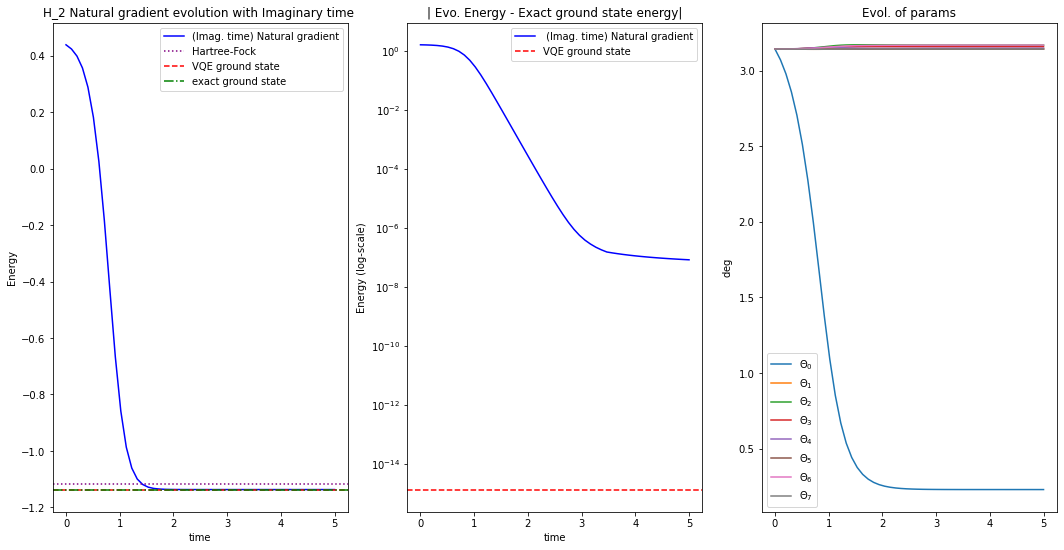

In [12]:
#PLOT
fig, (ax1, ax0, ax2) = plt.subplots(nrows=1, ncols=3,figsize=(18, 9))


ax1.set_title('H_2 Natural gradient evolution with Imaginary time ')
ax1.plot(timesteps,list_of_energies, color='blue',label='(Imag. time) Natural gradient')
ax1.axhline(res.hartree_fock_energy,linestyle='dotted', color='purple', label="Hartree-Fock")
ax1.axhline(vqe_energies,linestyle='--', color='red', label="VQE ground state")
ax1.axhline(exact_energy,linestyle='-.', color='green', label="exact ground state")

ax1.set_ylabel('Energy')
ax1.set_xlabel('time')
ax1.legend()


ax0.set_title('| Evo. Energy - Exact ground state energy|')
ax0.set_yscale('log')
ax0.plot(timesteps,list_of_energies-exact_energy, color='blue',label=' (Imag. time) Natural gradient')
ax0.axhline(vqe_energies-exact_energy,linestyle='--', color='red', label="VQE ground state")
ax0.set_ylabel('Energy (log-scale)')
ax0.set_xlabel('time')
ax0.set_yscale('log')
ax0.legend()


for i in range(numRep):
    ax2.plot(timesteps, list_of_angles[:-1,i], label="$\Theta_%s$"%str(i))
ax2.set_ylabel('$\deg$')
ax2.set_title('Evol. of params')
ax1.set_xlabel('time')
ax2.legend()


plt.savefig('AVQC_imaginary_time_evo_t'+str(T)+'.png')